In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Teoría

## 1- 10 puntos

La formula del R2 es:

$$R^2 = \frac{Var(errorPromedio) - Var(errorModelo)}{Var(errorPromedio)}$$

Convenceme que entiendes esta formula y porque esto tiene sentido


# 2- 20 puntos

¿Qué es una regresión lineal y para que sirve?
¿Qué es el gradiente descendiente? ¿Cómo uso eso para encontrar los mejores coeficientes de una regresión lineal?


Responde estas preguntas, convenceme que entiendes que es una regresión lineal y de donde salen los coeficientes

# 3- 5 puntos
¿Por qué hay empresas con valuaciones bajas respecto a sus ganancias?

## 4- 10 puntos

La utilidad de un activo es:

$$Utiliad = E[P] - \alpha *\frac{1}{2} Var(P) $$

Explica porque esto tiene sentido  en el mundo de los econos

## 5- 5 puntos
Explica en 3 renglones la hopitesis de mercados eficientes

# Práctica

### 30%

Baja del 2016 a 2021, de forma diaria las acciones de:


- Apple
- Amazon
- Discover
- Cotsco
- Starbucks


- Obten el portafolio de mínima varianza
- Obten una gráfica de todos los posibles portafolios
- Calcula la beta de cada uno de esos activos
- Calcula el R2 de cada uno de esos activos
- Cuanto debes invertir en ese portafolio dado los cooeficientes de aversión : [1, 2, 3, 4, 5, 6, 6, 7]
- Obten el R2 y Beta con bootstrap de cada uno de esos activos
  Responde: probabilidad beta > 1  y probabilidad r2 > 0.5
  
  
### CAPM, Fama french y 5 factores (20%)

Sobre el portafolio anterior, crea los 3 distintos modelos vistos en clase.

¿Cuál es el R2 de cada uno?  Crea un boostrap de cada uno de los R2

Explica conclusiones

#### Descarga de datos

In [2]:
np.random.seed(150)

tickers2 = ['AAPL', 'AMZN', 'DFS', 'COST', 'SBUX',
           'VTI']
tickers = tickers2.copy()
tickers.remove("VTI")
start_date = '2016-01-01'
end_date = "2021-12-31"

St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
Stock = yf.download(tickers2, start=start_date, end=end_date)['Adj Close']
rt = St.pct_change().dropna()
returns = Stock.pct_change().dropna()

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  6 of 6 completed


#### Portafolio de mínima varianza

In [3]:
sigma = rt.cov()

n_port = 10000
n_act = len(rt.keys())

W = np.random.dirichlet((1,) * n_act, size=n_port)

rendimientos = W.dot(rt.mean()) * 252

zeros = np.zeros(n_port)
for j in range(len(zeros)):
    zeros[j] = W[j, :].dot(sigma).dot(W[j, :])
volatility = zeros**(1/2) * 252**(1/2)

rf = 0.03

sharpe = (rendimientos - rf) / volatility

resultados = pd.DataFrame({
    "Expected_value": rendimientos,
    "Volatility": volatility,
    "Sharpe": sharpe
})

for j in range(len(tickers)):
    ticker_temp = tickers[j]
    resultados["W_" + ticker_temp] = W[:, j]

min_var = resultados[resultados.Volatility == resultados.Volatility.min()]
emv = resultados[resultados.Sharpe == resultados.Sharpe.max()]

emv_volatility = emv.Volatility.values[0]
emv_expected_value = emv.Expected_value.values[0]

min_var

,Expected_value,Volatility,Sharpe,W_AAPL,W_AMZN,W_DFS,W_COST,W_SBUX
5861,0.237684,0.18732,1.10871,0.006256,0.116799,0.579715,0.006662,0.290568


In [4]:
emv

,Expected_value,Volatility,Sharpe,W_AAPL,W_AMZN,W_DFS,W_COST,W_SBUX
7577,0.307328,0.207515,1.33642,0.351699,0.1625,0.452681,0.031241,0.001879


####Gráfica de todos los posibles portafolios

Text(0, 0.5, '$E[x]$')

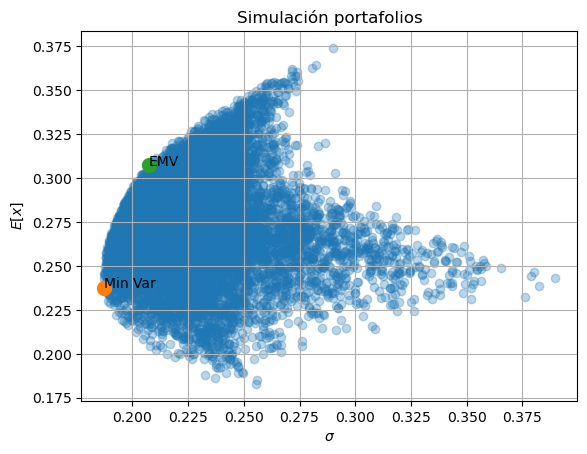

In [5]:
plt.figure()
plt.scatter(resultados.Volatility, resultados.Expected_value, alpha=0.3)
plt.scatter(min_var.Volatility, min_var.Expected_value, s=100)
plt.text(min_var.Volatility, min_var.Expected_value, "Min Var")
plt.scatter(emv.Volatility, emv.Expected_value, s=100)
plt.text(emv.Volatility, emv.Expected_value, "EMV")
plt.grid()
plt.title("Simulación portafolios")
plt.xlabel("$\sigma$")
plt.ylabel("$E[x]$")

####Betas y R2s de todos los activos

In [6]:
r2s = []
betas = []

for i in tickers:
    X = returns[["VTI"]]
    y = rt[[i]]

    #Calculo de beta
    model = LinearRegression().fit(X, y)
    beta = model.coef_[0][0]
    betas.append(beta)

    #Calculo de R2
    predictions = model.predict(X)
    r2 = r2_score(y_true=y, y_pred=predictions)
    r2s.append(r2)

df = pd.DataFrame()
df["tickers"] = tickers
df["betas"] = betas
df["r2"] = r2s
df

,tickers,betas,r2
0,AAPL,1.166020,0.532842
1,AMZN,0.924592,0.335324
2,DFS,1.630198,0.527663
3,COST,0.633836,0.310283
4,SBUX,0.990025,0.475362


####LAC con diferentes aversiones al riesgo

In [7]:
gamma = np.linspace(1, 8, 8)

lac_emv = pd.DataFrame({
    "gamma": gamma,
    "w_acciones": (emv_expected_value - rf) / (gamma * emv_volatility**2)
})

lac_emv["w_bonos"] = 1 - lac_emv.w_acciones

media_lac = lac_emv.w_acciones * emv_expected_value + lac_emv.w_bonos * rf
vol_lac = lac_emv.w_acciones * emv_expected_value

media = []
vol = []

for j in range(len(media_lac)):
    media.append(media_lac.values[j])
    vol.append(vol_lac.values[j])

lac_emv["media"] = media
lac_emv["vol"] = vol

lac_emv

,gamma,w_acciones,w_bonos,media,vol
0,1.0,6.440100,-5.440100,1.816017,1.979220
1,2.0,3.220050,-2.220050,0.923009,0.989610
2,3.0,2.146700,-1.146700,0.625339,0.659740
3,4.0,1.610025,-0.610025,0.476504,0.494805
4,5.0,1.288020,-0.288020,0.387203,0.395844
5,6.0,1.073350,-0.073350,0.327670,0.329870
6,7.0,0.920014,0.079986,0.285145,0.282746
7,8.0,0.805013,0.194987,0.253252,0.247403


####Bootstrap de beta y R2

In [8]:
betas_dict = {}
r2_dict = {}
model = LinearRegression()
n_reps = 1000

for i in tickers:
    betas_dict[i] = []
    r2_dict[i] = []
    for j in range(n_reps):
        #Betas
        flag_frame = returns.sample(len(returns), replace=True)
        X = flag_frame[["VTI"]]
        y = flag_frame[[i]]
        model.fit(X, y)
        beta = model.coef_[0][0]
        betas_dict[i].append(beta)

        #R2
        predictions = model.predict(X)
        r2 = r2_score(y_true=y, y_pred=predictions)
        r2_dict[i].append(r2)

df_betas_bootstrap = pd.DataFrame({})

for i in tickers:
    df_betas_bootstrap[i] = betas_dict[i]

df_betas_bootstrap

,AAPL,AMZN,DFS,COST,SBUX
0,1.123154,1.081058,1.500643,0.652717,1.052870
1,1.079490,0.886631,1.432427,0.723819,0.922172
2,1.138225,0.841365,1.689163,0.700374,0.931728
3,1.139138,0.921428,1.625822,0.706176,0.987326
4,1.148786,0.943387,1.487181,0.671506,0.955371
...,...,...,...,...,...
995,1.224957,0.904498,1.611877,0.672401,0.925695
996,1.148378,0.880934,1.782758,0.623321,0.906866
997,1.178806,0.947237,1.476376,0.702719,1.004851
998,1.175315,0.908761,1.635490,0.647930,1.001416


In [9]:
df_r2s_bootstrap = pd.DataFrame({})

for i in tickers:
    df_r2s_bootstrap[i] = r2_dict[i]

df_r2s_bootstrap

,AAPL,AMZN,DFS,COST,SBUX
0,0.511439,0.360440,0.435724,0.289275,0.522659
1,0.518793,0.351146,0.525720,0.360970,0.498692
2,0.567151,0.295374,0.541511,0.316663,0.429371
3,0.461805,0.282802,0.542456,0.357416,0.421586
4,0.534601,0.339428,0.467535,0.282026,0.462254
...,...,...,...,...,...
995,0.520328,0.328300,0.516260,0.337820,0.459899
996,0.486483,0.344096,0.599016,0.283942,0.387719
997,0.575945,0.332421,0.518708,0.307833,0.488155
998,0.552359,0.322959,0.567857,0.339066,0.477532


#####Preguntas sobre bootstrap

In [10]:
for i in tickers:
    print("La probabilidad de que la beta de " + i + " sea mayor a 1 es de: " + str(((df_betas_bootstrap[i] > 1).mean())))
    print("La probabilidad de que el R2 de " + i + " sea mayor a 0.5 es de: " + str(((df_r2s_bootstrap[i] > 0.5).mean())))
    print()

La probabilidad de que la beta de AAPL sea mayor a 1 es de: 1.0
La probabilidad de que el R2 de AAPL sea mayor a 0.5 es de: 0.825

La probabilidad de que la beta de AMZN sea mayor a 1 es de: 0.112
La probabilidad de que el R2 de AMZN sea mayor a 0.5 es de: 0.0

La probabilidad de que la beta de DFS sea mayor a 1 es de: 1.0
La probabilidad de que el R2 de DFS sea mayor a 0.5 es de: 0.733

La probabilidad de que la beta de COST sea mayor a 1 es de: 0.0
La probabilidad de que el R2 de COST sea mayor a 0.5 es de: 0.0

La probabilidad de que la beta de SBUX sea mayor a 1 es de: 0.429
La probabilidad de que el R2 de SBUX sea mayor a 0.5 es de: 0.315



#### CAPM, Fama french y 5 factores

In [11]:
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2021, 12, 31)

ff_factores = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start_date, end_date)

factors_df = ff_factores[0] / 100
factors_df.index = factors_df.index.to_timestamp()

In [12]:
stock_data = yf.download(tickers, start_date, end_date, interval='1mo')['Adj Close']
rt = stock_data.pct_change().dropna()

fama_french_df = pd.merge(rt, factors_df, on='Date')

[*********************100%%**********************]  5 of 5 completed


In [17]:
def run_all_models(data, ticker):
    flag_data = data.copy()
    flag_data[ticker + '_minus_RF'] = data[ticker] - data['RF']
    y = flag_data[[ticker + '_minus_RF']]

    # CAPM
    X_capm = flag_data[['Mkt-RF']]
    model_capm = LinearRegression().fit(X_capm, y)
    prediction_capm = model_capm.predict(X_capm)
    r2_capm = r2_score(y_pred=prediction_capm, y_true=y)
    summary_capm = {str(X_capm.keys().values): list(model_capm.coef_[0])}

    # 3 factor model
    X_3factor = flag_data[['Mkt-RF', 'SMB', 'HML']]
    model_3factor = LinearRegression().fit(X_3factor, y)
    prediction_3factor = model_3factor.predict(X_3factor)
    r2_3factor = r2_score(y_pred=prediction_3factor, y_true=y)
    summary_3factor = {str(X_3factor.keys().values): list(model_3factor.coef_[0])}


    # 5 factor
    X_5factor = flag_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    model_5factor = LinearRegression().fit(X_5factor, y)
    prediction_5factor = model_5factor.predict(X_5factor)
    r2_5factor = r2_score(y_pred=prediction_5factor, y_true=y)
    summary_5factor = {str(X_5factor.keys().values): list(model_5factor.coef_[0])}

    summary = {
        'CAPM': {'BETAS': summary_capm, 'R2': r2_capm},
        '3 factor': {'BETAS': summary_3factor, 'R2': r2_3factor},
        '5 factor': {'BETAS': summary_5factor, 'R2': r2_5factor}

    }
    return summary

fama_french_df['emv'] = emv.W_AAPL.values[0]*fama_french_df['AAPL'] + emv.W_AMZN.values[0]*fama_french_df['AMZN'] + emv.W_DFS.values[0]*fama_french_df['DFS'] +emv.W_COST.values[0]*fama_french_df['COST'] + emv.W_SBUX.values[0]*fama_french_df['SBUX']

run_all_models(fama_french_df, 'emv')

{'CAPM': {'BETAS': {"['Mkt-RF']": [1.3499064452154532]},
  'R2': 0.7510359029453093},
 '3 factor': {'BETAS': {"['Mkt-RF' 'SMB' 'HML']": [1.3401378703467113,
    0.04290060555609793,
    -0.0063563302386353444]},
  'R2': 0.7512884136840801},
 '5 factor': {'BETAS': {"['Mkt-RF' 'SMB' 'HML' 'RMW' 'CMA']": [1.2068633976789254,
    0.1854973687741721,
    0.1304044725111614,
    0.2900288116100799,
    -0.6981202932982792]},
  'R2': 0.779203753756122}}

In [15]:
fama_french_df

,AAPL,AMZN,COST,DFS,SBUX,Mkt-RF,SMB,HML,RMW,CMA,RF,emv
Date,,,,,,,,,,,,
2016-02-01,-0.006677,-0.058739,-0.007213,0.013758,-0.042126,-0.0007,0.0088,-0.0057,0.0325,0.0202,0.0002,-0.005970
2016-03-01,0.133327,0.074423,0.053171,0.103652,0.028949,0.0696,0.0107,0.0119,0.0077,-0.0008,0.0002,0.107621
2016-04-01,-0.139921,0.111094,-0.059970,0.105067,-0.058124,0.0091,0.0123,0.0328,-0.0297,0.0190,0.0001,0.014422
2016-05-01,0.065287,0.095817,0.007291,0.009597,-0.023830,0.0178,-0.0061,-0.0166,-0.0109,-0.0248,0.0001,0.043059
2016-06-01,-0.036831,-0.009920,0.055589,-0.051974,0.044268,-0.0005,0.0045,-0.0148,0.0140,0.0194,0.0002,-0.036273
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,0.040930,0.043034,0.061956,0.031371,-0.032447,0.0291,-0.0068,-0.0015,-0.0028,-0.0179,0.0000,0.037464
2021-09-01,-0.066640,-0.053518,-0.013480,-0.038219,-0.057468,-0.0437,0.0112,0.0508,-0.0196,0.0210,0.0000,-0.049964
2021-10-01,0.058657,0.026602,0.093891,-0.077574,-0.038437,0.0665,-0.0270,-0.0049,0.0166,-0.0145,0.0000,-0.007303


####Bootstrap R2

In [14]:
data = fama_french_df
bs_r2_capm = []
bs_r2_3f = []
bs_r2_5f = []
bootstrap_r2 = pd.DataFrame()

for i in range(100):
    flag_data = data.sample(frac = len(data), replace=True)
    flag_data['emv' + '_minus_RF'] = fama_french_df['emv'] - fama_french_df['RF']
    y = flag_data[['emv' + '_minus_RF']]

    #CAPM
    X_capm = flag_data[['Mkt-RF']]

    model_capm = LinearRegression().fit(X_capm, y)
    prediction_capm = model_capm.predict(X_capm)

    r2_capm = r2_score(y_pred=prediction_capm, y_true=y)
    bs_r2_capm.append(r2_capm)

    #3 factores
    X_3factor = flag_data[['Mkt-RF', 'SMB', 'HML']]

    model_3factor = LinearRegression().fit(X_3factor, y)
    prediction_3factor = model_3factor.predict(X_3factor)

    r2_3factor = r2_score(y_pred=prediction_3factor, y_true=y)
    bs_r2_3f.append(r2_3factor)

    #5 factores
    X_5factor = flag_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

    model_5factor = LinearRegression().fit(X_5factor, y)
    prediction_5factor = model_5factor.predict(X_5factor)

    r2_5factor = r2_score(y_pred=prediction_5factor, y_true=y)
    bs_r2_5f.append(r2_5factor)


bootstrap_r2["CAPM"] = bs_r2_capm
bootstrap_r2["3_factores"] = bs_r2_3f
bootstrap_r2["5_factores"] = bs_r2_5f
bootstrap_r2

,CAPM,3_factores,5_factores
0,0.755232,0.755393,0.785574
1,0.747879,0.748254,0.772983
2,0.760230,0.760582,0.784946
3,0.736966,0.737946,0.766250
4,0.747972,0.749040,0.779181
...,...,...,...
95,0.757753,0.757831,0.784215
96,0.742583,0.742803,0.772795
97,0.744835,0.745118,0.770085
98,0.755573,0.756261,0.782418
